## 1. GCN的问题

GCN的训练方式是基于全图的形式，然而对于许多实际的业务场景，图的规模是非常巨大的，单张显卡的容量难以满足一张整图训练所需要的空间，所以小批量的训练方法对于大规模图数据的训练是十分必要的。

此外，GCN要求在训练前知道整个图的结构信息，这也极大的限制了它的应用场景。


## 2. GraphSage

GraphSage通过采样邻居的策略将GCN的训练方式由全图(Full Batch)方式修改为以节点为中心的小批量(Mini Batch)的方式，这使得大规模图数据的分布式训练成为可能。


![Visual illustration of the GraphSAGE sample and aggregate approach](images/graphsage_routing.png)

### 2.1 采样邻居

GNN模型中，图的信息聚合过程是沿着Graph Edge进行的，GNN中节点在第(k+1)层的特征只与其在(k)层的邻居有关，这种局部性质使得节点在(k)层的特征只与自己的k阶子图有关。因此对于k层网络，只需要采样Graph的k阶子图，就可以满足训练的需求。

同时为了提升运算效率，对每个顶点的邻居节点进行有放回的采样，保证每个节点邻居个数都是相同的。这也是神经网络中处理数据的一种常用的策略。

In [1]:
def sampling(src_nodes, sample_num, neighbor_table):
    """根据源节点采样指定数量的邻居节点，注意使用的是有放回的采样；
    某个节点的邻居节点数量少于采样数量时，采样结果出现重复的节点
    
    Arguments:
        src_nodes {list, ndarray} -- 源节点列表
        sample_num {int} -- 需要采样的节点数
        neighbor_table {dict} -- 节点到其邻居节点的映射表
    
    Returns:
        np.ndarray -- 采样结果构成的列表
    """
    results = []
    for sid in src_nodes:
        # 从节点的邻居中进行有放回地进行采样
        res = np.random.choice(neighbor_table[sid], size=(sample_num, ))
        results.append(res)
    return np.asarray(results).flatten()


def multihop_sampling(src_nodes, sample_nums, neighbor_table):
    """根据源节点进行多阶采样
    
    Arguments:
        src_nodes {list, np.ndarray} -- 源节点id
        sample_nums {list of int} -- 每一阶需要采样的个数
        neighbor_table {dict} -- 节点到其邻居节点的映射
    
    Returns:
        [list of ndarray] -- 每一阶采样的结果
    """
    sampling_result = [src_nodes]

    for k, hopk_num in enumerate(sample_nums):
        hopk_result = sampling(sampling_result[k], hopk_num, neighbor_table)
        sampling_result.append(hopk_result)
    return sampling_result

### 2.2 聚合邻居节点

由于在图(Graph)中顶点的邻居是无序的，所以聚合函数最好是对称的，即无论如何改变输入的顺序，函数的输出结果总是不变的。

常用的有如下几个聚合算子：

1) 均值(Mean)/加和(Sum)聚合算子：

$$Agg_{sum} = \sigma (\text{SUM} \{W h_j + b\}),  \forall v_j \in N(v_i)$$

$$Agg_{mean} = \sigma (\text{MEAN} \{W h_j + b\}),  \forall v_j \in N(v_i)$$

2) 池化(Pooling)聚合算子：

$$Agg_{pool} = \sigma (\text{MAX} \{W h_j + b\}),  \forall v_j \in N(v_i)$$


In [ ]:
class NeighborAggregator(tf.keras.Model):
    def __init__(self, input_dim, output_dim, 
                 use_bias=False, aggr_method="mean"):
        """聚合节点邻居
        Args:
            input_dim: 输入特征的维度
            output_dim: 输出特征的维度
            use_bias: 是否使用偏置 (default: {False})
            aggr_method: 邻居聚合方式 (default: {mean})
        """
        super(NeighborAggregator, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.aggr_method = aggr_method

        self.weight = self.add_weight(shape = (self.input_dim, self.output_dim),
                                      initializer = 'glorot_uniform',
                                      name = 'kernel')

        if self.use_bias:
            self.bias = self.add_weight(shape = (self.input_dim, self.output_dim),
                                        initializer = 'zero',
                                        name = 'bias')

    def call(self, neighbor_feature):
        if self.aggr_method == "mean":
            aggr_neighbor = tf.math.reduce_mean(neighbor_feature, axis = 1)
        elif self.aggr_method == "sum":
            aggr_neighbor = tf.math.reduce_sum(neighbor_feature, axis = 1)
        elif self.aggr_method == "max":
            aggr_neighbor = tf.math.reduce_max(neighbor_feature, axis = 1)
        else:
            raise ValueError("Unknown aggr type, expected sum, max, or mean, but got {}"
                             .format(self.aggr_method))
        
        neighbor_hidden = tf.matmul(aggr_neighbor, self.weight)
        if self.use_bias:
            neighbor_hidden += self.bias

        return neighbor_hidden

## 3. 模型训练

这里我们使用的Cora数据集，该数据集由2708篇论文的特征、分类以及它们之间引用关系的5429条边组成，这些论文的类型被划分为7个类别:Case_Based、Genetic_Algorithms、Neural_Networks、Probabilistic_Methods、Reinforcement_Learning、Rule_Learning、Theory。最终实现的目标是，输入一篇论文的特征，就可以输出该论文属于哪个分类。

可以看到，这里我们不再将整个Cora Dataset作为网络的输入，而是把Trainning Data分为一个个的Batch喂给模型。

In [ ]:
data = CoraData().data()

train_index = np.where(data.train_mask)[0]
train_label = data.y[train_index]
test_index = np.where(data.test_mask)[0]
val_index = np.where(data.val_mask)[0]

model = GraphSage(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM,
                  num_neighbors_list=NUM_NEIGHBORS_LIST)

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, decay=5e-4)

def train():
    for e in range(EPOCHS):
        for batch in range(NUM_BATCH_PER_EPOCH):
            batch_src_index = np.random.choice(train_index, size=(BTACH_SIZE,))
            batch_src_label = train_label[batch_src_index].astype(float)

            batch_sampling_result = multihop_sampling(batch_src_index, NUM_NEIGHBORS_LIST, data.adjacency_dict)
            batch_sampling_x = [data.x[np.array(idx.astype(np.int32))] for idx in batch_sampling_result]

            with tf.GradientTape() as tape:
                batch_train_logits = model(batch_sampling_x)
                loss = loss_object(batch_src_label, batch_train_logits)
                grads = tape.gradient(loss, model.trainable_variables)

                optimizer.apply_gradients(zip(grads, model.trainable_variables))

            print("Epoch {:03d} Batch {:03d} Loss: {:.4f}".format(e, batch, loss))

在Tensorflow 2.0中实现代码时，出现："No gradients provided for any variable"的错误，追了半天，才在stackoverflow上找到原因：

https://stackoverflow.com/questions/58947679/no-gradients-provided-for-any-variable-in-tensorflow2-0

> Yup, this is a mildly annoying thing about GradientTape. You cannot do anything to the tensors outside the tape context (with...) or the tape will "lose track". You can fix it by simply moving the addition into the context:

在测试集和验证集上测试模型的精度的代码如下:

In [2]:
def test(index):
    test_sampling_result = multihop_sampling(index, NUM_NEIGHBORS_LIST, data.adjacency_dict)
    test_x = [data.x[idx.astype(np.int32)] for idx in test_sampling_result]
    test_logits = model(test_x)
    test_label = data.y[index]

    ll = tf.math.equal(tf.math.argmax(test_label, -1), tf.math.argmax(test_logits, -1))
    accuarcy = tf.reduce_mean(tf.cast(ll, dtype=tf.float32))

    return accuarcy

最后，把模型跑起来，看看效果。

Process data ...
Loading cora dataset...
Dataset has 2708 nodes, 2708 edges, 1433 features.
Epoch 000 train accuracy: 0.7733333110809326 val accuracy: 0.508571445941925 test accuracy:0.4180253744125366
Epoch 001 train accuracy: 0.9599999785423279 val accuracy: 0.7142857313156128 test accuracy:0.6607789993286133
Epoch 002 train accuracy: 0.9933333396911621 val accuracy: 0.7457143068313599 test accuracy:0.648097813129425
Epoch 003 train accuracy: 1.0 val accuracy: 0.7142857313156128 test accuracy:0.6503623127937317
Epoch 004 train accuracy: 1.0 val accuracy: 0.7142857313156128 test accuracy:0.6557971239089966
Epoch 005 train accuracy: 1.0 val accuracy: 0.7200000286102295 test accuracy:0.6557971239089966
Epoch 006 train accuracy: 1.0 val accuracy: 0.7171428799629211 test accuracy:0.65625
Epoch 007 train accuracy: 1.0 val accuracy: 0.7342857122421265 test accuracy:0.65625
Epoch 008 train accuracy: 1.0 val accuracy: 0.7285714149475098 test accuracy:0.6598731875419617
Epoch 009 train accurac

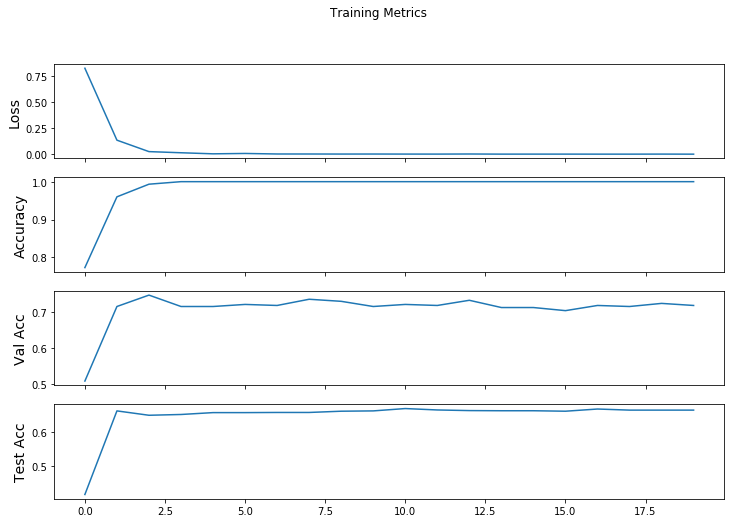

In [1]:
from train import train

train()